## 1.6 Homework

The goal of this homework is to train a simple model for predicting the duration of a ride - similar to what we did in this module.


## Q1. Downloading the data

We'll use [the same NYC taxi dataset](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page),
but instead of "Green Taxi Trip Records", we'll use "For-Hire Vehicle Trip Records".

Download the data for January and February 2021.

Note that you need "For-Hire Vehicle Trip Records", not "High Volume For-Hire Vehicle Trip Records".

Read the data for January. How many records are there?

* 1054112
* 1154112
* 1254112
* 135411

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta

In [47]:
df = pd.read_parquet("https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-01.parquet")
df

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037
...,...,...,...,...,...,...,...
1154107,B03266,2021-01-31 23:43:03,2021-01-31 23:51:48,7.0,7.0,None,B03266
1154108,B03284,2021-01-31 23:50:27,2021-02-01 00:48:03,44.0,91.0,None,
1154109,B03285,2021-01-31 23:13:46,2021-01-31 23:29:58,171.0,171.0,None,B03285
1154110,B03285,2021-01-31 23:58:03,2021-02-01 00:17:29,15.0,15.0,None,B03285


## Q2. Computing duration  Now let's compute the `duration` variable. It should contain the duration of a ride in minutes.   What's the average trip duration in January?  * 15.16 * 19.16 * 24.16 * 29.16

In [48]:
df['duration'] = (df['dropOff_datetime'] - df['pickup_datetime'])
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
df['duration'].mean()

19.167224093791006

## Data preparation

Check the distribution of the duration variable. There are some outliers. 

Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

How many records did you drop?

44286


<AxesSubplot:ylabel='Frequency'>

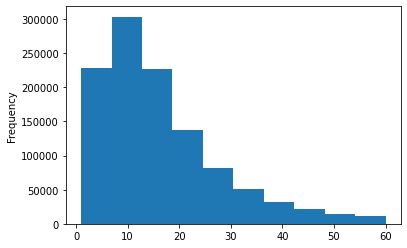

In [49]:
print(df.shape[0] - ((df['duration'] >=1) & (df['duration'] <= 60)).sum())
df = df[(df.duration >= 1) & (df.duration <= 60)]
df['duration'].plot.hist()

## Q3. Missing values

The features we'll use for our model are the pickup and dropoff location IDs. 

But they have a lot of missing values there. Let's replace them with "-1".

What's the fractions of missing values for the pickup location ID? I.e. fraction of "-1"s after you filled the NAs.

* 53%
* 63%
* 73%
* 83%

In [50]:
df[['PUlocationID', 'DOlocationID']].isna().sum()/df.shape[0]

PUlocationID    0.835273
DOlocationID    0.133270
dtype: float64

In [51]:
df[['PUlocationID', 'DOlocationID']] = df[['PUlocationID', 'DOlocationID']].fillna(-1)
df[['PUlocationID', 'DOlocationID']]

C:\Users\w10\AppData\Local\Temp\ipykernel_65280\2277339329.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['PUlocationID', 'DOlocationID']] = df[['PUlocationID', 'DOlocationID']].fillna(-1)


,PUlocationID,DOlocationID
0,-1.0,-1.0
1,-1.0,-1.0
3,-1.0,72.0
4,-1.0,61.0
5,-1.0,71.0
...,...,...
1154107,7.0,7.0
1154108,44.0,91.0
1154109,171.0,171.0
1154110,15.0,15.0


## Q4. One-hot encoding

Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model. 

* Turn the dataframe into a list of dictionaries
* Fit a dictionary vectorizer 
* Get a feature matrix from it

What's the dimensionality of this matrix? (The number of columns).

* 2
* 152
* 352
* 525
* 725

In [55]:
categorical = ['dispatching_base_num', 'pickup_datetime', 'dropOff_datetime', 'SR_Flag', 'Affiliated_base_number']
numerical = ['PUlocationID',	'DOlocationID']

df[categorical] = df[categorical].astype(str)
df[numerical] = pd.get_dummies(df[numerical])

train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)


C:\Users\w10\AppData\Local\Temp\ipykernel_65280\472127144.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical].astype(str)
C:\Users\w10\AppData\Local\Temp\ipykernel_65280\472127144.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numerical] = pd.get_dummies(df[numerical])


## Q5. Training a model

Now let's use the feature matrix from the previous step to train a model. 

* Train a plain linear regression model with default parameters 
* Calculate the RMSE of the model on the training data

What's the RMSE on train?

* 5.52
* 10.52
* 15.52
* 20.52

In [56]:
X_train

<1109826x1577519 sparse matrix of type '<class 'numpy.float64'>'
	with 7768782 stored elements in Compressed Sparse Row format>

In [57]:
target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

4.40726738071524

c:\Users\w10\Documents\Python Scripts\mlops-zoomcamp\.venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\w10\Documents\Python Scripts\mlops-zoomcamp\.venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


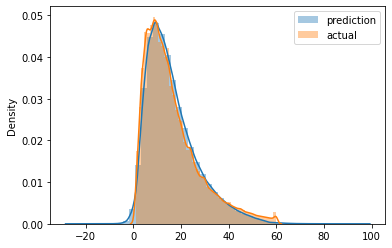

In [60]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

## Q6. Evaluating the model

Now let's apply this model to the validation dataset (Feb 2021). 

What's the RMSE on validation?

* 6.01
* 11.01
* 16.01
* 21.01

In [23]:
dft = pd.read_parquet("https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-02.parquet")
dft

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00013,2021-02-01 00:01:00,2021-02-01 01:33:00,NaN,NaN,None,B00014
1,B00021,2021-02-01 00:55:40,2021-02-01 01:06:20,173.0,82.0,None,B00021
2,B00021,2021-02-01 00:14:03,2021-02-01 00:28:37,173.0,56.0,None,B00021
3,B00021,2021-02-01 00:27:48,2021-02-01 00:35:45,82.0,129.0,None,B00021
4,B00037,2021-02-01 00:12:50,2021-02-01 00:26:38,NaN,225.0,None,B00037
...,...,...,...,...,...,...,...
1037687,B03282,2021-02-28 23:01:16,2021-02-28 23:14:48,NaN,31.0,None,B01717
1037688,B03282,2021-02-28 23:36:10,2021-02-28 23:47:38,NaN,169.0,None,B01717
1037689,B03285,2021-02-28 23:18:36,2021-02-28 23:43:59,28.0,171.0,None,B03285
1037690,B03285,2021-02-28 23:26:34,2021-02-28 23:44:37,16.0,252.0,None,B03285


In [24]:
dft['dropOff_datetime'] = pd.to_datetime(dft['dropOff_datetime'])
dft['pickup_datetime'] = pd.to_datetime(dft['pickup_datetime'])
dft['pickup_datetime']

0         2021-02-01 00:01:00
1         2021-02-01 00:55:40
2         2021-02-01 00:14:03
3         2021-02-01 00:27:48
4         2021-02-01 00:12:50
                  ...        
1037687   2021-02-28 23:01:16
1037688   2021-02-28 23:36:10
1037689   2021-02-28 23:18:36
1037690   2021-02-28 23:26:34
1037691   2021-02-28 23:24:00
Name: pickup_datetime, Length: 1037692, dtype: datetime64[ns]

In [25]:
dft.dtypes

dispatching_base_num              object
pickup_datetime           datetime64[ns]
dropOff_datetime          datetime64[ns]
PUlocationID                     float64
DOlocationID                     float64
SR_Flag                           object
Affiliated_base_number            object
dtype: object

In [26]:
dft['duration'] = (dft['dropOff_datetime'] - dft['pickup_datetime'])

dft.duration = dft.duration.apply(lambda td: td.total_seconds() / 60)

dft[['PUlocationID', 'DOlocationID']] = dft[['PUlocationID', 'DOlocationID']].fillna(-1)

categorical = ['dispatching_base_num', 'pickup_datetime', 'dropOff_datetime', 'SR_Flag', 'Affiliated_base_number']
numerical = ['PUlocationID',	'DOlocationID']

dft[categorical] = dft[categorical].astype(str)
dft[numerical] = pd.get_dummies(dft[numerical])

train_dicts = dft[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_test = dv.fit_transform(train_dicts)

target = 'duration'
y_test = dft[target].values

lr = LinearRegression()
lr.fit(X_test, y_test)

y_pred = lr.predict(X_test)

mean_squared_error(y_test, y_pred, squared=False)

73.26038597896587